<h1>Observable Trends</h1>
<ul>
<li>The months with the most precipitation are September, March, May, and July.</li>
<li>The most active station shows the lowest temperature (54.0°F), highest temperature (85.0°F), and average (71.7°F) over the last twelve months.</li>
<li>The predicted temperature for the trip dates (2017-08-17 to 2017-08-23) are low: 71.0, average: 79.0, high: 85.0 with .13 inches of rain.</li>
</ul>

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
one_year = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database
#Reference for relativedelta
#https://stackoverflow.com/questions/546321/how-do-i-calculate-the-date-six-months-from-the-current-date-using-the-datetime
year_ago = dt.date(2017,8,23) - relativedelta(years=1)
year_ago

datetime.date(2016, 8, 23)

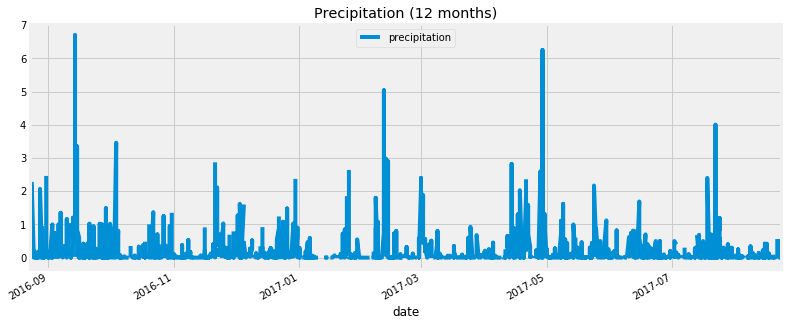

In [9]:
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(query,columns=['date', 'precipitation'])

# Change datatype from element to datetime object on Pandas
prcp_df['date'] = pd.to_datetime(prcp_df['date'], format='%Y-%m-%d')

# Sort the dataframe by date
prcp_df.set_index('date', inplace=True)
prcp_df = prcp_df.sort_values(by='date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Precipitation (12 months)", figsize=(12,5))
plt.legend(loc='upper center')
plt.savefig("output/Precipitation.png")
plt.show()

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [11]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().count()
stations

9

In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,
                                func.count(Measurement.station)).group_by(Measurement.station).\
                                order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
data = [func.min(Measurement.tobs), 
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)]

temp_data = session.query(*data).\
    filter(Measurement.station == "USC00519281").all()
temp_data

[(54.0, 85.0, 71.66378066378067)]

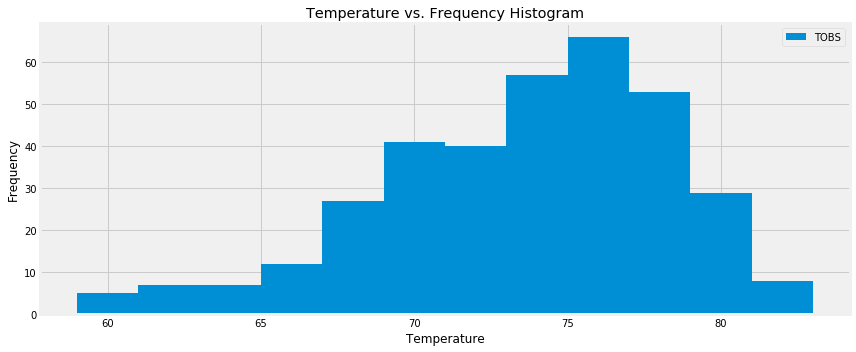

In [14]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_data = session.query(Measurement.tobs).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).all()

USC00519281_data_df = pd.DataFrame(USC00519281_data, columns=["TOBS"])

# Put into 12 bins for 12 months
USC00519281_data_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram", figsize=(12,5))
plt.xlabel("Temperature")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("output/Temp_vs_Frequency.png")
plt.show()